<img src="images/logo/eooffshore_banner.png" width="48%" />&nbsp;

<img src="images/logo/seai.png" width="25%" /> <span /> <img src="images/logo/ucd.png" width="7%" />

# Sentinel-1 Wind Data for Irish Continental Shelf region

## Introduction

The [European Union Copernicus Earth Observation (EO) programme](https://www.copernicus.eu/en/about-copernicus) and services are based on data collected from EO satellites, in particular, the [Sentinel satellite missions](https://sentinels.copernicus.eu/web/sentinel/home). This includes the [Sentinel-1 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-1), which consists of a pair of C-band Synthetic Aperture Radar (SAR) imaging satellites in polar orbit. One of its main objectives is the provision of ocean monitoring services, where its [Level-2 Ocean (OCN) products](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-2) include an Ocean WInd field (OWI) component. This provides gridded estimates of wind speed and direction at 10m above the surface, with a typical spatial resolution of 1 km. Examples of Sentinel-1 SAR usage for ocean wind analysis are described in the following publications:

* [Ahsbahs et al. (2018) - Applications of satellite winds for the offshore wind farm site Anholt](https://doi.org/10.5194/wes-3-573-2018)
* [Ahsbahs et al. (2020) - US East Coast synthetic aperture radar wind atlas for offshore wind energy](https://doi.org/10.5194/wes-5-1191-2020)
* [de Montera et al. (2020) - Validation of Sentinel-1 offshore winds and average wind power estimation around Ireland](https://doi.org/10.5194/wes-5-1023-2020)
* [Hasager et al. (2020) - Europe’s offshore winds assessed with synthetic aperture radar, ASCAT and WRF over France](https://doi.org/10.5194/wes-5-375-2020)
* [Longépé et al. (2021) - Co-Cross-Polarization Coherence Over the Sea Surface From Sentinel-1 SAR Data: Perspectives for
Mission Calibration and Wind Field Retrieval and Norwegian Sea](https://doi.org/10.1109/TGRS.2021.3055979)


This notebook provides details of:
1. Sentinel-1 wind data products retrieval.
1. The creation of the Sentinel-1 Zarr wind store that is included in the EOOffshore catalog.
1. A brief look at this Zarr store, including a demonstration of wind speed calculation.

**How to cite:** O'Callaghan, D. and McBreen, S.: Scalable Offshore Wind Analysis With Pangeo, EGU General Assembly 2022, Vienna, Austria, 23–27 May 2022, EGU22-2746, [https://doi.org/10.5194/egusphere-egu22-2746](https://doi.org/10.5194/egusphere-egu22-2746), 2022.

**Note: more extensive usage of the EOOffshore Sentinel-1 Zarr store may be found in the following notebooks:**
* [Offshore Wind in Irish Areas Of Interest](./Offshore_Wind_AOI.ipynb)
* [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb)

--------------------------------------------------
## Sentinel-1 Wind Data Products

The EOOffshore project uses [Sentinel-1 Level-2 Ocean (OCN) wind products](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-2) data set, which provide ocean wind estimates from 2015 to the present day. The following data variables are relevant:

| Variable | Unit | Height (metres above sea level) | Description |
| ----------- | ----------- | ----------- | ----------- |
| `owiWindSpeed` | $m/s$ | 10 | SAR Wind speed |
| `owiWindDirection` | degrees | 10 | SAR Wind direction (meteorological convention = <br/>clockwise direction from where the wind comes <br/>respect to North) |
| `owiWindQuality` | Dimensionless | n/a | Quality flag taking into account the `consistency_between_wind`<br/>`_inverted_and_NRCS_and_Doppler_measured`. <br/>0 = good; 1 = medium; 2 = low; 3 = poor. |

Data products from all Sentinel missions, including those from Sentinel-1 observations, are publicly available via the [Copernicus Open Access Hub (COAH)](https://scihub.copernicus.eu/). Products are distributed using a Sentinel-specific variation of the [Standard Archive Format for Europe (SAFE) format specification](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/data-formats/safe-specification). Retrieving products from the COAH is typically a two-stage process using the [Sentinelsat library](https://sentinelsat.readthedocs.io/en/stable/)

1. Query the COAH for all Sentinel-1 Level-2 product identifiers available for a specified time period that are contained within the [Irish Continental Shelf (ICS)](https://www.marine.ie/Home/site-area/irelands-marine-resource/real-map-ireland) region
1. Retrieve product for each identifier listed in the query results

Older data products may no longer be accessible from the COAH, where these are often moved to the Long Term Archive (LTA), (see [related discussion](https://forum.step.esa.int/t/esa-copernicus-data-access-long-term-archive-and-its-drawbacks/15394)). As Sentinel-1 Level-2 products (back to 2015) are also hosted by the [Alaska Satellite Facility (ASF)](https://search.asf.alaska.edu/#/), any products no longer available in the COAH set were retrieved from the ASF using the [`aria2c` utility](https://docs.asf.alaska.edu/api/tools/). The following products were retrieved using a combination of the COAH and ASF archives:

|       |  |
| ----------- | ----------- |
| **Observation / Models** | Satellite |
| **Product type** | Near-Real-Time |
| **Processing level** | Level-2 |
| **Data type** | Gridded (latitude/longitude) |
| **Horizontal coverage** | Individual products within [ICS maritime limits](https://data.gov.ie/dataset/maritime-limits-irish-continental-shelf) |
| **Horizontal resolution** | 1 km |
| **Vertical coverage** | Single level |
| **Temporal coverage** | 2015-06-07T18:21:04 to 2021-09-29T18:07:48 |
| **Temporal resolution** | [12-day repeat frequency (6-day with two-satellite Sentinel-A/B constellation)](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/revisit-and-coverage) |
| **Update frequency** | [Daily](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-1/data-distribution-schedule) |
| **File format** | NetCDF-4 |
| **Total retrieved products** | 17,698 SAFE (containing 22,950 NetCDF-4) |
| **Total products size** | 241G |

------------------------------------------------
## Sentinel-1 Wind Zarr Store

As the retrieved NetCDF products (within the SAFE archives) are Level-2 products featuring heterogeneous curvilinear grids, they were initially regridded to a uniform grid using [xESMF](https://pangeo-xesmf.readthedocs.io/en/latest/index.html). A spatial resolution of 0.03 degrees was specified for this grid, which is similar to resolutions used in earlier Sentinel-1 ocean wind analysis ([Ahsbahs et al., 2020](https://doi.org/10.5194/wes-5-1191-2020); [de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020)). Each Level-2 product is associated with an observation time, and it was necessary to assign a `time` coordinate dimension prior to further processing. Although each product provides a `firstMeasurementTime` value, this appears to only contain unique values for [Single VV (SV) polarization](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-product-formatting) products. For all other products, the ["Stop Date and Time" contained in the product filename](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-product-formatting) was used as the unique `time` coordinate. A `height` coordinate dimension (10m) was also added for the `owi...` variables. Using small product batch chunks, a chunked, compressed [Zarr](https://zarr.readthedocs.io/en/stable/) store, which is a cloud-optimised format suitable for multi-dimensional arrays, was created by concatenating products along the `time` dimension. This Zarr store was then rechunked in space (`x` - longitude, `y` - latitude dimensions) using [Rechunker](https://github.com/pangeo-data/rechunker), where a `time` chunk size was specified that resulted in a low number of `time` chunks. This approach is more suitable for subsequent processing of variables over time for Areas Of Interest (AOIs). Retaining only the `owi...` variables results in considerably lower storage requirements in this final rechunked Zarr store (1.2GB) compared to the original products that were retrieved.

As requested by the [Legal Notice on the use of Copernicus Sentinel Data and Service Information](https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice), this Zarr store:
* Contains modified Copernicus Sentinel data [2015 - 2021].

-----------------------------------------------
## Sentinel-1 in EOOffshore Catalog

Imports required for subsequent processing

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
from intake import open_catalog
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.geometry as sgeom
import xarray as xr

sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

### Open the catalog and view the Sentinel-1 metadata

All EOOffshore data sets, including the Sentinel-1 Zarr store described above, are accessible using the EOOffshore [Intake](https://intake.readthedocs.io/en/latest/) catalog. Each [catalog](https://intake.readthedocs.io/en/latest/catalog.html) entry provides a description and metadata associated with the corresponding data set, defined in a [YAML configuration file](https://intake.readthedocs.io/en/latest/catalog.html#yaml-format). The EOOffshore catalog configuration was originally influenced by the [Pangeo Cloud Data Store atmosphere.yaml catalog configuration](https://github.com/pangeo-data/pangeo-datastore/blob/master/intake-catalogs/atmosphere.yaml). 

To view the Sentinel-1 metadata:

In [2]:
catalog = open_catalog('data/intake-catalogs/eooffshore_ics.yaml')
catalog.eooffshore_ics_level3_sentinel1_ocn

eooffshore_ics_level3_sentinel1_ocn:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/scihub/s1_ocn/201501_202109/eooffshore_ics_level3_sentinel1_ocn.zarr
  description: EOOffshore Project 2015 - 2021 Concatenated Sentinel-1 Level 2 OCN
    wind (owiWind...) variable products from Copernicus, for Irish Continental Shelf.
    Products have been regridded with xESMF (bilinear) to a Level 3 grid, NW (-26,
    58), SE (-4, 46), grid resolution = 0.03 degrees. Contains modified Copernicus
    Sentinel data [2015 - 2021].
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - sentinel1
    - ocean
    title: Sentinel-1 L2 OCN owiWind variables regridded to level 3 Irish Continental
      Shelf grid (resolution = 0.03 degrees)
    url: https://sentinels.copernicus.eu/web/sentinel/ocean-wind-field-component


------------------------------------------------------
### Load the catalog Sentinel-1 Zarr store

Intake catalog entries typically specify a [driver](https://intake.readthedocs.io/en/latest/catalog.html#driver-selection) to be used when loading the corresponding data set. The Sentinel-1 entry specifies [`intake_xarray.xzarr.ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource), a driver implementation provided by the [intake-xarray](https://intake-xarray.readthedocs.io/) library. This enables NetCDF and Zarr data sets to be loaded using [xarray](https://docs.xarray.dev/en/stable/index.html), a library for processing N-D labeled arrays and datasets. As xarray labels take the form of dimensions, coordinates and attributes on top of [NumPy](https://numpy.org/)-like arrays, it is particularly suited to data sets such as CCMP whose variables feature latitude/longitude grid coordinates.

This intake driver will load the associated dataset into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). To enable support for potentially large data sets, the [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) function is used to load the underlying variable arrays with [Dask](https://docs.dask.org/en/latest/), a parallel, out-of-core computing library. The [`ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource) implementation will load the data set variables into [Dask arrays](https://docs.dask.org/en/latest/array.html), which will be loaded and processed in parallel as [chunks](https://docs.dask.org/en/latest/array.html) during subsequent computation. As discussed above, variable chunk sizes may be specified during Zarr store creation.

Here is the Sentinel-1 store loaded into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html):

* All variables have associated coordinate dimensions:
  * `time` - unique observation time of eacb original Level-2 product
  * `x` (longitude) and `y` (latitude) - the corresponding coordinate grid generated during regridding with xESMF
  * `height` - 10m (above sea level)
* A low number of `time` chunks have been specified, to support subsequent computation across time for smaller AOI grid coordinates.

In [3]:
ds = catalog.eooffshore_ics_level3_sentinel1_ocn.to_dask()
# Enable consistent variable naming
ds = ds.rename({'owiWindDirection': 'wind_direction', 'owiWindSpeed': 'wind_speed'})

ds

<xarray.Dataset>
Dimensions:         (height: 1, y: 401, x: 734, time: 18545)
Coordinates:
  * height          (height) int64 10
    latitude        (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
    longitude       (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
  * time            (time) datetime64[ns] 2015-06-07T18:21:04 ... 2021-09-29T...
Dimensions without coordinates: y, x
Data variables:
    wind_direction  (time, height, y, x) float32 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
    owiWindQuality  (time, height, y, x) float64 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
    wind_speed      (time, height, y, x) float32 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
Attributes:
    eooffshore_zarr_creation_time:  2022-05-13T14:02:25Z
    eooffshore_zarr_details:        EOOffshore Project: Concatenated Sentinel...

----------------------------------------------------------------
### Sentinel-1 wind quality flag

Sentinel-1 OCN products contain an `owiWindQuality` variable, which reflects the quality of corresponding wind variables at a particular time.

Each variable in the Sentinel-1 data set, including `owiWindQuality`, is loaded into an [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html):
* The arrays are transposed here to produce more intuitive `time` chunk visualisations. This is not required for computation.

In [4]:
ds.owiWindQuality.transpose('height', 'time', 'y', 'x')

<xarray.DataArray 'owiWindQuality' (height: 1, time: 18545, y: 401, x: 734)>
dask.array<transpose, shape=(1, 18545, 401, 734), dtype=float64, chunksize=(1, 18545, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * height     (height) int64 10
    latitude   (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-06-07T18:21:04 ... 2021-09-29T18:07:48
Dimensions without coordinates: y, x
Attributes:
    coordinates:    lon lat
    flag_meanings:  good medium low poor
    flag_values:    [0, 1, 2, 3]
    long_name:      Quality flag taking into account the consistency_between_...
    valid_range:    [0, 3]

#### Plot the mean wind quality across time for all grid coordinates

According to the [Sentinel-1 Product Specification (Issue/Revision: 3/9, Date: 07/05/2021)](https://sentinels.copernicus.eu/documents/247904/1877131/S1-RS-MDA-52-7441-3-9-2_Sentinel-1ProductSpecification.pdf/4f4488ef-60ad-52cb-160c-71ebdf6ca820?t=1641274625444):
* "*Wind quality flag (`owiWindQuality`) values can be 0 (high quality), 1 (medium quality), 2 (low quality) or 3 (bad quality).*

Previous analysis of Sentinel-1 OCN products ([de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020)) excluded "bad quality" observations (`owiWindQuality` = 3). Here, the following plots look at mean `owiWindQuality` across the `time` dimension:

1. Mean `owiWindQuality` for all observations
1. Mean `owiWindQuality`, excluding "bad quality" observations

Using Dask, the data set loading process is lazy, where no data is loaded inititally. Instead, data loading is [delayed until execution time, where variables will be loaded and processed in parallel according to the corresponding chunks specification](https://tutorial.dask.org/01x_lazy.html). Dask arrays implement a subset of the NumPy [`ndarray`](https://numpy.org/doc/stable/reference/arrays.ndarray.html) interface using blocked algorithms, and the original variable arrays will be split into smaller chunk arrays, enabling computation on arrays larger than memory using all available cores. The blocked algorithms are coordinated using [Dask graphs](https://docs.dask.org/en/stable/graphs.html).

Here, mean `owiWindQuality` over the `time` dimension is initially determined for all grid coordinates, where Dask graph execution is triggered by calling [`compute()`](https://docs.dask.org/en/stable/api.html#dask.compute). The resulting variable values will be contained in a NumPy `ndarray`.

Graph execution is managed by a [task scheduler](https://docs.dask.org/en/stable/scheduling.html). The default scheduler (used for executing this notebook) executes computations with [local threads](https://docs.dask.org/en/stable/scheduling.html#local-threads). However, execution may also be performed on a [distributed cluster](https://docs.dask.org/en/stable/scheduling.html#dask-distributed-local) **without any change to the `xarray` code used here**.

Map plots of variables with grid coordinates may be generated using [xarray's plotting capabilities](https://docs.xarray.dev/en/latest/user-guide/plotting.html), and other libraries. To plot mean `owiWindQuality`:
* Specify a suitable projection using [Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
* Call the variable [`xarray.DataArray.plot()`](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)
* Load the [ICS maritime limits](https://data.gov.ie/dataset/maritime-limits-irish-continental-shelf) geometry with [Shapely](https://shapely.readthedocs.io/en/stable/manual.html#linestrings)
* Specifying a Cartopy projection will use a [`GeoAxes`, which is a subclass of a regular matplotlib `Axes`](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html). This may be used to plot the following:
  * ICS boundary
  * Variable grid (latitude/longitude) lines
  * Ireland coastline

In [5]:
with open('data/linestring_ics_geo.json') as jf:
    icsgeo = json.load(jf)
icsline = sgeom.LineString(icsgeo['features'][0]['geometry']['coordinates'])

In [6]:
MAP_PROJECTION = ccrs.PlateCarree()

def plot_ics_variable(ax: mpl.axes.Axes, 
                      variable: xr.DataArray, 
                      title: str, 
                      vmin: float, 
                      vmax: float = None, 
                      cmap: mpl.colors.Colormap = 'inferno_r'):
    # x and y must be specified for 2-d grids
    variable.plot(x='longitude', y='latitude', cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_aspect('auto')

    # ICS boundary
    ax.add_geometries([icsline], MAP_PROJECTION, edgecolor = sns.color_palette()[0], facecolor='none')

    # Lat/lon gridlines
    gl = ax.gridlines(draw_labels=['left', 'bottom'], alpha=0.2, linestyle='--', formatter_kwargs=dict(direction_label=False))
    label_style = {'size': 10}
    gl.xlabel_style = label_style
    gl.ylabel_style = label_style
    
    ax.set_title(title);

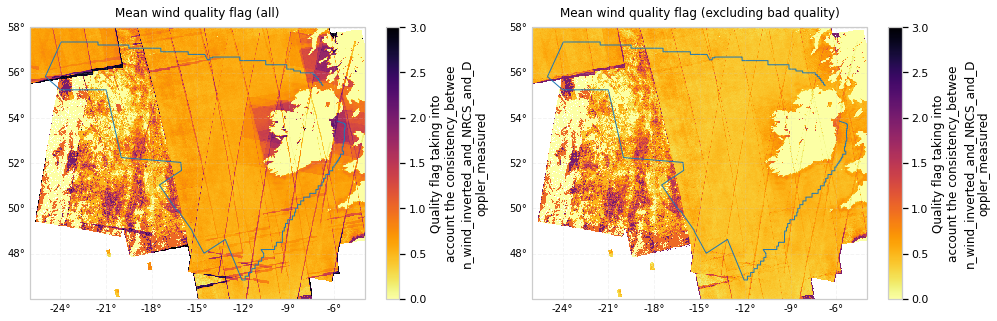

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5, 5), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()

quality_title = 'Mean wind quality flag'

plot_ics_variable(variable=ds.where(ds.owiWindQuality >= 0).owiWindQuality.mean('time', keep_attrs=True).compute(),
                  title=f'{quality_title} (all)',
                  vmin=0,
                  vmax=3,
                  ax=ax[0])

ds = ds.where((ds.owiWindQuality >= 0) & (ds.owiWindQuality <= 2))

plot_ics_variable(variable=ds.owiWindQuality.mean('time', keep_attrs=True).compute(),
                  title=f'{quality_title} (excluding bad quality)',
                  vmin=0,
                  vmax=3,
                  ax=ax[1])

#### Plot the mean number of SAR observations across time for all grid coordinates

A minimum number of SAR observations are required for wind speed analysis (for example, [Hasager et al., 2015](https://doi.org/10.1016/j.rse.2014.09.030); [Badger et al., 2016](https://doi.org/10.1175/JAMC-D-15-0197.1)). Based on the following plot of total observations per grid cell, it is clear that observations are not uniformly distributed across the Sentinel-1 ICS grid. A histogram of the SAR observations distribution is also displayed, using [`xarray.plot.hist()`](https://docs.xarray.dev/en/latest/generated/xarray.plot.hist.html), along with corresponding distribution statistics.

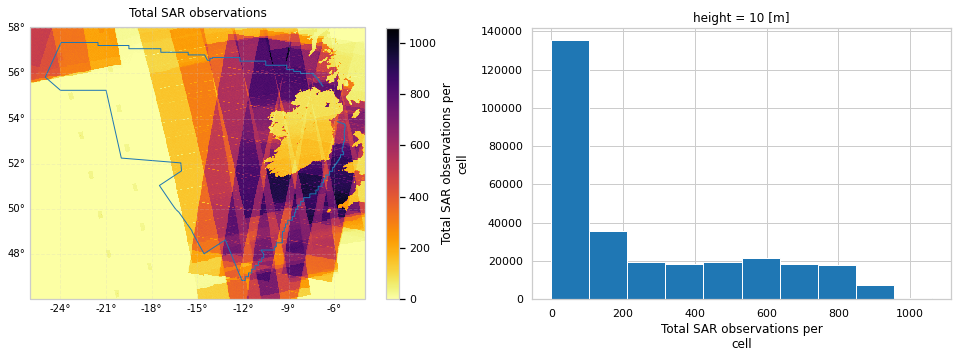

In [8]:
ds['total_sar_observations'] = ds.wind_speed.count('time').compute()
ds.total_sar_observations.attrs.update({'long_name': 'Total SAR observations per cell'})

fig = plt.figure(figsize=(16.5, 5))

plot_ics_variable(variable=ds.total_sar_observations,
                  title=f'Total SAR observations',
                  vmin=ds.total_sar_observations.min().item(),
                  vmax=ds.total_sar_observations.max().item(),
                  ax=plt.subplot(121, projection=MAP_PROJECTION),
                  cmap='inferno_r')

xr.plot.hist(ds.total_sar_observations.sel(height=10), ax=plt.subplot(122));

In [9]:
ds.total_sar_observations.to_dataframe().total_sar_observations.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
total_sar_observations,294334.0,254.171346,289.59132,0.0,2.0,137.0,503.0,1060.0


#### Retain only cells with quality in [0, 2] and a minimum number of observations ($\ge$ 200)

Excluding cells with low numbers of SAR observations does not noticeably reduce coverage of Irish offshore AOIs.

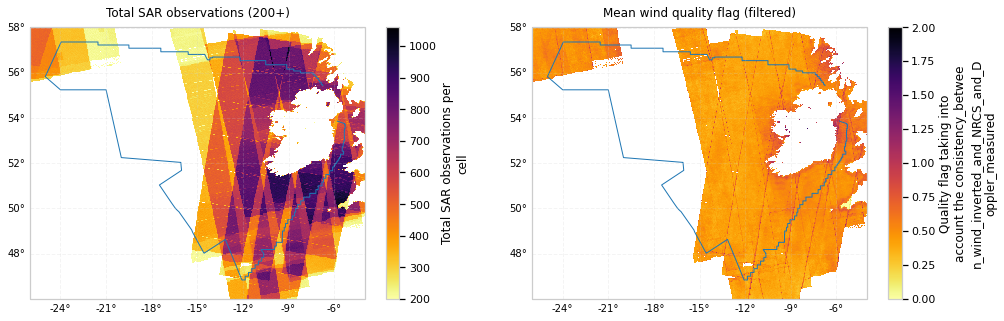

In [10]:
ds = ds.where(ds.total_sar_observations >= 200)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.5, 5), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()

quality_title = 'Mean wind quality flag'

plot_ics_variable(variable=ds.total_sar_observations,
                  title=f'Total SAR observations (200+)',
                  vmin=ds.total_sar_observations.min().item(),
                  vmax=ds.total_sar_observations.max().item(),
                  ax=ax[0])

plot_ics_variable(variable=ds.owiWindQuality.mean('time', keep_attrs=True).compute(),
                  title=f'{quality_title} (filtered)',
                  vmin=0,
                  vmax=2,
                  ax=ax[1])

----------------------------------------------------------------
### Sentinel-1 wind speed (2015 - 2021)

Wind speed is loaded into an [`xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html):

In [11]:
ds.wind_speed.transpose('height', 'time', 'y', 'x')

<xarray.DataArray 'wind_speed' (height: 1, time: 18545, y: 401, x: 734)>
dask.array<transpose, shape=(1, 18545, 401, 734), dtype=float32, chunksize=(1, 18545, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * height     (height) int64 10
    latitude   (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-06-07T18:21:04 ... 2021-09-29T18:07:48
Dimensions without coordinates: y, x
Attributes:
    coordinates:    lon lat
    long_name:      SAR Wind speed
    standard_name:  wind_speed
    units:          m/s

#### Calculate mean wind speed over `time` dimension at AOI grid coordinates

To perform some analysis at known AOI latitude/longitude coordinates, the [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html) function may be used to select a subset of the data array (or data set) at coordinates nearest to the specified parameters. 
Here, mean wind speed over the `time` dimension is determined for the specified coordinates. 
* **Note:** [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html) does not support selection from two-dimensional curvilinear grids as used in the regridded Sentinel-1 data set. Consequently, [`xarray.DataArray.isel()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.isel.html) is used here with the `x` (longitude) and `y` (latitude) dimensions for demonstration. A solution enabling two-dimensional grid selection is described in the [Offshore Wind in Irish Areas Of Interest](./Offshore_Wind_AOI.ipynb) notebook.

In [12]:
ds.wind_speed.isel(x=390, y=150).mean(dim='time').compute()

<xarray.DataArray 'wind_speed' (height: 1)>
array([9.388478], dtype=float32)
Coordinates:
  * height     (height) int64 10
    latitude   float64 50.52
    longitude  float64 -14.28